<a href="https://colab.research.google.com/github/eli-vigneron/Deep-Learning-Pytorch/blob/main/neural_network_hessian_spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**<br>
For a labeled dataset $\{x_i,y_i\}_{i=1}^N$, the Hessian of the loss is defined as

$H = \sum_{i=1}^N \frac{\partial^2 \mathcal{L}(f(x_i;\theta),y_i)}{\partial \theta^2} \in \mathbb{R}^{p \times p}.$

The goal of this is to train a neural network and to calculate---at the beginning and at the end of training---the spectrum of the Hessian:

$\{\lambda_i(H) \ : \ i=1,\dots,p\}$.

This implementation will have a high runtime complexity. We will therefore:
* train a small network;
* on a subset of the MNIST dataset;
* and down-sample the images to $8 \times 8$ pixels.

*Requires including a GPU*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from scipy.sparse.linalg import svds

%matplotlib inline

In [ ]:
# hyperparameters
device          = "cuda"
epochs          = 100
lr              = 0.1
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4

In [ ]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(8**2, 10)
        self.fc2 = nn.Linear(10, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc2(F.relu(self.fc1(x)))

# dataset
transform = transforms.Compose([transforms.Resize(8),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

dataset = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)

# subsample dataset
subset = torch.utils.data.Subset(dataset, range(0, len(dataset), 100))

train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)

train_loader_2 = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                             shuffle=True, drop_last=False)

# loss function
loss_function = nn.CrossEntropyLoss()

loss_function_2 = nn.CrossEntropyLoss(reduction='sum')

Train		Epoch: 1 	Batch 1/4 (25%) 	Batch Loss: 2.342683 	Batch Accuracy: 7.031250
Train		Epoch: 1 	Batch 2/4 (50%) 	Batch Loss: 2.352458 	Batch Accuracy: 8.203125
Train		Epoch: 1 	Batch 3/4 (75%) 	Batch Loss: 2.300156 	Batch Accuracy: 7.291667
Train		Epoch: 1 	Batch 4/4 (100%) 	Batch Loss: 2.197735 	Batch Accuracy: 9.960938
Train		Epoch: 2 	Batch 1/4 (25%) 	Batch Loss: 2.226146 	Batch Accuracy: 14.843750
Train		Epoch: 2 	Batch 2/4 (50%) 	Batch Loss: 2.121523 	Batch Accuracy: 20.312500
Train		Epoch: 2 	Batch 3/4 (75%) 	Batch Loss: 2.170209 	Batch Accuracy: 19.791667
Train		Epoch: 2 	Batch 4/4 (100%) 	Batch Loss: 2.026408 	Batch Accuracy: 19.726562
Train		Epoch: 3 	Batch 1/4 (25%) 	Batch Loss: 2.037476 	Batch Accuracy: 21.875000
Train		Epoch: 3 	Batch 2/4 (50%) 	Batch Loss: 1.787405 	Batch Accuracy: 28.515625
Train		Epoch: 3 	Batch 3/4 (75%) 	Batch Loss: 1.825560 	Batch Accuracy: 31.250000
Train		Epoch: 3 	Batch 4/4 (100%) 	Batch Loss: 1.708742 	Batch Accuracy: 35.156250
Train		Epoch: 4 	

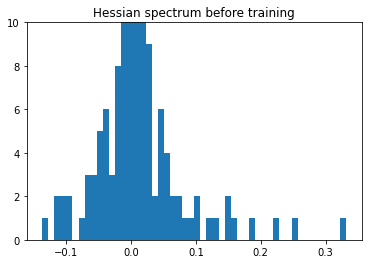

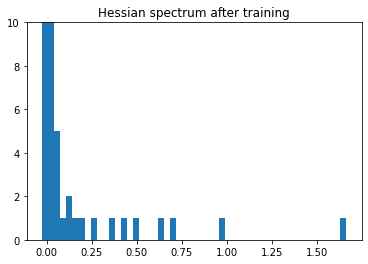

In [ ]:
# initialize model
model = MLP().to(device)

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

# very useful functions
def list_to_vector(list_):
    return torch.cat([x.view(-1) for x in list_])


def vector_to_list(vector):
    list_ = []
    counter = 0
    for param in list(model.parameters()):
        list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
        counter += torch.numel(param)
    return list_

# total_number_of_parameters
p = sum(param.numel() for param in model.parameters() if param.requires_grad)

def calculate_Hessian_spectrum(title):
    def Hessian_vector_multiplication(vector):
        Hv = 0
        N = 0
        for images, labels in train_loader_2:
            N += images.shape[0]
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images)
            loss = loss_function_2(logits, labels)

            # TASK 1: ADD CODE HERE
            vector = vector.to(device)
            grad = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            Hv = torch.autograd.grad(list_to_vector(list(grad)), model.parameters(), vector)
            Hv = list_to_vector(list(Hv))

        return Hv/N

    def get_Hessian_column(i):
        # TASK 2: ADD CODE HERE
        e_i = torch.zeros(p)
        e_i[i]=1
        column = Hessian_vector_multiplication(e_i)
        return column


    # TASK 3: ADD CODE HERE
    H_list = [get_Hessian_column(j) for j in range(p)]
    H = torch.cat(H_list, dim=0)
    H = torch.reshape(H, (p, p))
    H = H.T

    # plot spectrum
    plt.figure()
    eigval,_ = torch.eig(H)
    plt.hist(eigval[:,0].detach().cpu(), bins=50)
    plt.ylim([0,10])
    plt.title(title)

calculate_Hessian_spectrum('Hessian spectrum before training')

# iterate over epochs
for epoch in range(1, epochs+1):
    model.train()

    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
        
calculate_Hessian_spectrum('Hessian spectrum after training')